https://www.kaggle.com/c/icdar2013-gender-prediction-from-handwriting<br> https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/<br> 
https://medium.com/@kylepob61392/airplane-image-classification-using-a-keras-cnn-22be506fdb53<br> 
http://overfitt.io/posts/large-image-datasets-keras/

In [2]:
# importing the necessary package
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from keras.preprocessing.image import img_to_array, load_img

import glob
import os.path as path
import pandas as pd
import numpy as np


C:\Temp\Python\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# reading the train answer.csv file
train_answers = pd.read_csv('train_answers.csv')

In [4]:
# Generating the path of each images and sorting it
image_path = 'data'
file_paths = glob.glob(path.join(image_path,'*.jpg'))
file_paths.sort()

In [5]:
# Creating a new dataframe with only the file_path and the writer ID
COLUMN_NAMES=['file_path', 'writer']
dataframe = pd.DataFrame(columns=COLUMN_NAMES)
dataframe['file_path']= file_paths

In [6]:
# From the dataframe, we need to extract the writer ID from the file path
# the format of the file path is 'data\<writer_id>_<number>.jpg
dataframe['writer'] = dataframe['file_path'].str.extract(r'(\d+)_(\d+).jpg', expand=True)
# Set the writer column as a Category
dataframe['writer'] = pd.Categorical(dataframe['writer']).codes


In [7]:
# Now we need to merge the dataframe to the train_answer dataframe in order to add the male
# column for each writer
merged_dataframe = pd.merge(dataframe, train_answers, how ='right', on = ['writer'])
# as in the train_answer we only have identified 282 writers, every writer IDs > 282 will be
# removed

In [8]:
# Now we can build the X_train and y_train dataframe to be used by the model
X = merged_dataframe['file_path']
y = merged_dataframe['male']

In [9]:
# reading a specific line and checking if the write type is correct
test_data = merged_dataframe.loc[merged_dataframe['file_path'] == 'data\\0034_4.jpg']
test_data.head()

,file_path,writer,male
131,data\0034_4.jpg,33,0


In [11]:

#Keras image generators allow you to preprocess batches of images in real-time.
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=True, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=True, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=20, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
        horizontal_flip=False, # randomly flip images
        vertical_flip=False) # randomly flip images


# Hyperparameter: defining how many convolutional layers for our CNN model
N_layers = 4

def cnn(size, n_layers):
    # size : size of the input images
    # n_layers : number of layers
    # model : compiled CNN
    
    # define local hyperparameters
    min_neurons = 20
    max_neurons = 120
    kernel = (3,3)
    
    # determine the number of neurons in each convolutionnal layer
    steps = np.floor(max_neurons / (n_layers + 1))
    neurons = np.arange(min_neurons, max_neurons, steps)
    neurons = neurons.astype(np.int32)
    
    # define a model 
    model = Sequential()

    # add convolutional layers
    for  i in range(0,n_layers):
        if i == 0:
            shape = (size[0],size[1], size[2])
            model.add(Conv2D(neurons[i], kernel, input_shape= shape))
        else:
            model.add(Conv2D(neurons[i], kernel))
        model.add(Activation('relu'))
        
        #Add max pooling layer
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(max_neurons))
        model.add(Activation('relu'))
        
        #Add output layer
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        #complie the model
        model.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
        
        # print a summary of the model
        model.summary()
        
        return model

In [12]:
#from keras.preprocessing import image
#test_image = image.load_img(X_train[1], 
#            target_size = (244, 244))
#test_image = image.img_to_array(test_image)
#
## scale the raw pixel intensities to the range [0, 1]
#test_image = np.array(test_image, dtype="float") / 255.0
##test_image

In [13]:
# instantiating the model
image_size = (244,244,3)
model = cnn(size = image_size , n_layers = N_layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 242, 242, 20)      560       
_________________________________________________________________
activation_1 (Activation)    (None, 242, 242, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 121, 121, 20)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 292820)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               35138520  
_________________________________________________________________
activation_2 (Activation)    (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 121       
__________

In [15]:
# Defining functions to read and convert the images into numpy array
def load_my_image(img_path, target_size=(244, 244)):
#    print('Image path size: ')
#    display(type(img_path))
#    im = load_img(img_path, target_size=target_size)
    images = [misc.imread(path, target_size=target_size) for path in file_paths]
#    images = [misc.imread(path) for path in  X_batches[0]]    
# scale the raw pixel intensities to the range [0, 1]
    images = np.array(images, dtype="float") / 255.0
#  return img_to_array(im) #converts image to numpy array
    return images #converts image to numpy array
             
def split_and_load(X_samples, y_samples, batch_size=100):
    target_size=(244, 244)
    batch_size = len(X_samples) / batch_size
    X_batches = np.array_split(X_samples, batch_size)
    y_batches = np.array_split(y_samples, batch_size)
#    display('After the splitting')
#    display('before the map call')
#    display(type( X_batches[0]))
#    test = np.array(map(load_my_image, X_batches[0]))
#    test = X_batches[0].map(load_my_image)
#    display('after the map call')
    
#    display(test.shape)
    for b in range(len(X_batches)):
#        display(b)
        print('Before loading the image X_batches: ', b , len(X_batches[b]))
        print('Before loading the image y_batches: ', b , len(y_batches[b]))
#        x = np.array(map(load_my_image, X_batches[b]))
        x = [img_to_array(load_img(path, target_size=target_size)) for path in X_batches[b]]
        x = np.array(x, dtype="float") / 255.0
        y = np.array(y_batches[b])
        display('After loading the image x: ', x.size)
        display('After loading the image y: ', y.size)        
        yield x, y             

In [ ]:
n_epoch = 1
batch_size = 32
for e in range(n_epoch):
  print( "epoch", e)
  for X_train, y_train in split_and_load(X, y):# chunks of 100 images
#        display(X_train.size)
#        display(y_train.size)
        for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32):# chunks of 32 samples
            loss = model.train_on_batch(X_batch, y_batch, verbose = 2)


epoch 0
Before loading the image X_batches:  0 103
Before loading the image y_batches:  0 103


'After loading the image x: '

18396624

'After loading the image y: '

103

C:\Temp\Python\Anaconda3\lib\site-packages\keras\preprocessing\image.py:536: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Temp\Python\Anaconda3\lib\site-packages\keras\preprocessing\image.py:544: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
# Make a prediction on the test set
test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

In [ ]:
import matplotlib.pyplot as plt
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())

## PCA Handling 

In [9]:
#loading the full batch of images
all_images = [img_to_array(load_img(path, target_size=(64,64))) for path in X]

In [12]:
images_array = np.array(all_images, dtype="float") / 255.0

In [16]:
images_array.shape

(1128, 64, 64, 3)

In [34]:
#y.shape


1128

(1128, 12288)

In [33]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(images_array, y, test_size = 0.22, random_state = 0)

In [35]:
# scikit-learn expects 2d num arrays for the training dataset for a fit function. The dataset 
# you are passing in is a 3d array you need to reshape the array into a 2d.
dataset_size = len(x_train1)
display(dataset_size)
TwoDim_dataset = x_train1.reshape(dataset_size,-1)
display(TwoDim_dataset.shape)

879

(879, 12288)

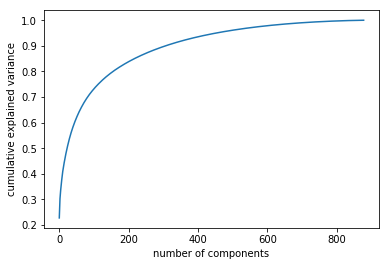

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA().fit(TwoDim_dataset)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
#plt.xlim([-10,50])